In [1]:
from lib import *

# Partial differential equations - wave-type equations

## Scheme: 

1. Discretize the spatial dimention: $u_n=u(x_n,t)$  (for example $x_n=nh$) 

2. write a system of $N$ second order (or $2N$ first order) time differential equations:
$$\partial_{tt}u_n=D_{nm}u_m-F_n$$


* write a system of $𝑁$ second order equations:

    $$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

    $$D_{n,m} =\frac{1}{dx^2} \cdot(\delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m} ), \qquad n,m = 0,1,2,3,..., N-1$$
    


3. use some time-stepping method to solve the system for given initial conditions $u(x, 0), \partial_t u(x, 0)$ and boundary conditions, such as $u(0,t)=f(x)$ and $u(L,t)=g(x)$.
* Runge-Kutta method
* simplectic method


# sine-Gordon model:

$$ \partial_{tt}u = \partial_{xx}u - \sin(u)$$

1. initial conditions:

* $u(x, 0) = 0 \qquad (position)$

* $\partial_t u(x, 0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad x = 0, L \\ 0  \qquad for \qquad 0<x<L \end{array} \right. \qquad (velocity)$

2. boundary conditions:

* $u(0, t) = \sin( \omega t) \qquad $

* $u(L, t) = \sin( \omega t) \qquad $


### Implementation:

1. spatial dimention discretization:

* $ x_n = n\cdot h \qquad n=0,1,2,3,...,N-1$

* $ u_n(t) = u(t, x_n)$



2. discretized initial conditions:

* $u_n(0) = 0 \qquad (position)$

* $\partial_t u_n(0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad n = 0, Nx \\ 0  \qquad for \qquad 0<n<Nx \end{array} \right. \qquad (velocity)$




3. discretized boundary conditions:

* $u_0(t) = \sin( \omega t) \qquad $

* $u_{N-1}(t) = -\sin( \omega t) \qquad $




4. write a system of $𝑁$ second order equations:

$$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}$$

$$ \partial_{tt}u_n =  \frac{u_{n-1}-2u_n+u_{n+1}}{h^2} - \sin(u_n) = D_{n,m}u_m - sin(u_n)$$

where:
$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}, \qquad n,m = 0,1,2,3,..., Nx$$

5. 
* $n,m = 0,1,2,3,..Nx$ - indexing of spatial coordinates
* $i,j = 0,1,2,3,..Nt$ - indexing of temporal coordinates


In [2]:
def get_D_second_order(N):
    
    '''
        𝐷𝑛,𝑚 = 𝛿𝑛−1,𝑚 − 2𝛿𝑛,𝑚 + 𝛿𝑛+1,𝑚
        No boundary conditions included
        
    '''
    D = np.diagflat( np.ones(N) * (-2))
    
    for i in range(1,N-1):
        D[i][i+1] = 1
        D[i][i-1] = 1
    
    return D

## Initialization:

In [3]:
azim1 = 10
azim2 = -60
elev = 25

cmap = 'Greys'

In [4]:
Nx= 100   ##(50, 40000)
Nt = 10000

T = 5
L = 2

ω1 = 2*PI / T
ω2 = 2*PI / T 

xx = np.linspace(0, L, Nx+1)
tt = np.linspace(0, T, Nt+1)

x,t = np.meshgrid(xx,tt)

dx = xx[1] - xx[0]
dt = tt[1] - tt[0]
print("dx = {:}\t dt = {:}\t dt/dx^2 = {:}".format(dx, dt, (1/dx**2 * dt)))

D = get_D_second_order(Nx+1)

dx = 0.02	 dt = 0.0005	 dt/dx^2 = 1.25


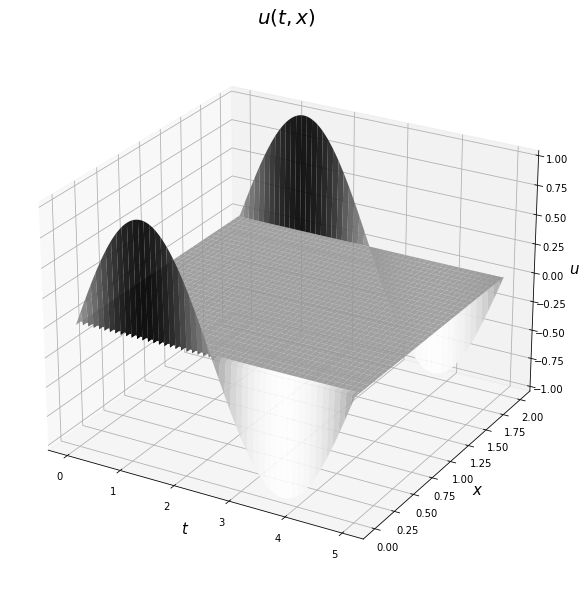

In [5]:
u = np.zeros((Nt+1,Nx+1))  ## position
v = np.zeros((Nt+1,Nx+1))  ## velocity, v = du/dt 

# set initial conditions at t=0 for position u(t,x)
u[0,:] = 0

# set initial conditions at t=0 for velocity u'(t,x)
v[0, 1:-1] = 0
v[0,0] = ω1 
v[0,-1] = ω2

## set boundary conditions:
u[:,0] = np.sin(ω1 * tt)   
u[:,-1] = np.sin(ω2 * tt) 

plot_3D(t,x,u, elev=elev, azim=azim2, cmap = cmap)

### simplectic method:
$$ \partial_t u^i = v^i $$
$$ \partial_{tt} u^i = \partial_t v^i = G(u^i)$$

multistep:
$$ u^{i+1/2} = u^i + \frac12 v^i dt = k^i $$
$$ v^{i+1} = v^i + G\left(u_{i+1/2}\right) dt $$
$$ u^{i+1} = u^{i+1/2}+\frac12 v^i dt $$

In our case this is:

$$ G(u^i) =  G(u^i_n) = D_{n,m}u_m - \sin(u_n) $$

$$ u^{i+1/2}_n = u^i_n + \frac12 v^i_n \cdot dt = k^i_m $$

$$ v^{i+1}_n = v^i_n + G\left(u^{i+1/2}_n\right) \cdot dt $$

$$ u^{i+1}_n = u^{i+1/2}_n +\frac12 v^i_n \cdot dt $$

In [6]:
def simplectic_1(Nt, Nx, u, v, dx,dt, D): 
    
    for i in range(0,Nt):
        tmp = np.empty(Nx+1)  
        tmp[:] = u[i, :] + 0.5 * v[i, :] * dt    
        v[i+1,:] = v[i, :]  - np.sin(tmp)* dt  
        v[i+1,:] += dt/(dx*dx) * np.matmul(D, tmp) 
        u[i+1,:] = tmp + 0.5 * v[i, :]* dt     
        ## re-set boundary conditions:
        u[i+1:,0] = np.sin(ω1 * (i+1)*dt)   
        u[i+1:,-1] = np.sin(ω2 * (i+1)*dt)       
    return u,v


def simplectic_2(Nt, Nx, u, v, dx, dt):  
    
    for i in range(0,Nt):     
        tmp = np.zeros(Nx+1)          
        tmp[:] = u[i,:] + 0.5 * v[i, :] * dt     
        v[i+1,:] = v[i, :] - np.sin(tmp)* dt 
        v[i+1, 1:-1] += dt/(dx*dx) * (tmp[:-2] - 2*tmp[1:-1] + tmp[2:])      
        u[i+1,1:-1] = (tmp + 0.5 * v[i, :]* dt)[1:-1]
    return u,v

def simplectic_3(Nt, Nx, u, v, dx,dt):
     
    for i in range(0,Nt):
        tmp = np.zeros(Nx+1)        
        tmp[:] = u[i,:] + 0.5 * v[i, :] * dt    
        v[i+1,:] = v[i, :]  - np.sin(tmp)* dt      
        v[i+1, 1:-1] += dt/(dx*dx) * np.diff(tmp[:], 2)   
        u[i+1,1:-1] = (tmp + 0.5 * v[i, :]* dt)[1:-1]
    return u,v

### Runge–Kutta–Nyström Methods:

for $$u'' = f(x,u,u')$$ initial value problems $u(x_0) = u_0$, $u'(x_0) = u'_0$  we may use Runge-Kutta-Nyström method:

$$u_{n+1} = u_n + hu'_n + h^2 \sum _{i=0}^m \bar{b}_i k'_i$$

$$u'_{n+1} = u'_n + h \sum _{i=0}^m b_i k'_i$$


$$ k'_i = f(x_n + c_i h, u_n + c_i h u'_n + h^2 \sum _{j=1}^m \bar{a}_{ij} k'_j)$$

$m$  = number of stages




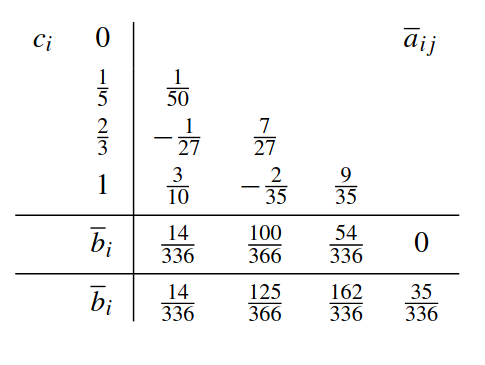

for example:

* $ k'_1 = f(x_n, u_n)$

* $ k'_2 = f(x_n + c_2 h, u_n + c_2 h u'_n + h^2 a_{21} k'_1)$

* $ k'_3 = f(x_n + c_3 h, u_n + c_3 h u'_n + h^2 a_{31} k'_1) + h^2 a_{32} k'_2) $

* $ k'_4 = f(x_n + c_4 h, u_n + c_4 h u'_n + h^2 a_{41} k'_1) + h^2 a_{42} k'_2) + h^2 a_{43} k'_3) $

$a_{ij}$ , $b_i$, $c_i$ are taken from the Butcher tableau 

In [7]:
from numba import jit, njit
import time


In [8]:
def f1(u, dx):

    return  1.0/(dx*dx) * (u[:-2] - 2*u[1:-1] + u[2:]) - np.sin(u[1:-1])
    
def Runge_Kutta_Nyström_1(Nt, Nx, u, v, dx, dt, a,b,d,c): 

    for i in range(0,Nt):   
        
        k0 = np.zeros(Nx+1)     
        k1 = np.zeros(Nx+1)          
        k2 = np.zeros(Nx+1)     
        k3 = np.zeros(Nx+1)
         
        
        k0[1:-1] = f1(u[i, :], dx)
        k1[1:-1] = f1(u[i, :] + c[1]*dt*v[i, :] + dt*dt*a[1][0]*k0, dx)       
        k2[1:-1] = f1(u[i, :] + c[2]*dt*v[i, :] + dt*dt*a[2][0]*k0 + dt*dt*a[2][1]*k1, dx)
        k3[1:-1] = f1(u[i, :] + c[3]*dt*v[i, :] + dt*dt*a[3][0]*k0 + dt*dt*a[3][1]*k1 + dt*dt*a[3][2]*k2, dx)

        u[i+1,1:-1] = u[i, 1:-1] + dt * v[i, 1:-1] + dt*dt* (b[0]*k0 + b[1]* k1 + b[2]*k2 + b[3]*k3 )[1:-1]
        
        v[i+1,:] = v[i, :]
        v[i+1, :] +=  dt* (d[0]*k0 + d[1]* k1 + d[2]*k2 + d[3]*k3 )

    return u,v

In [9]:
@jit 
def f2(u, dx):

    return  1.0/(dx*dx) * (u[:-2] - 2*u[1:-1] + u[2:]) - np.sin(u[1:-1])
    
@jit 
def Runge_Kutta_Nyström_2(Nt, Nx, u, v, dx, dt, a,b,d,c): 

    for i in range(0,Nt):   
        
        k0 = np.zeros(Nx+1)     
        k1 = np.zeros(Nx+1)          
        k2 = np.zeros(Nx+1)     
        k3 = np.zeros(Nx+1)
         
        
        k0[1:-1] = f2(u[i, :], dx)
        k1[1:-1] = f2(u[i, :] + c[1]*dt*v[i, :] + dt*dt*a[1][0]*k0, dx)       
        k2[1:-1] = f2(u[i, :] + c[2]*dt*v[i, :] + dt*dt*a[2][0]*k0 + dt*dt*a[2][1]*k1, dx)
        k3[1:-1] = f2(u[i, :] + c[3]*dt*v[i, :] + dt*dt*a[3][0]*k0 + dt*dt*a[3][1]*k1 + dt*dt*a[3][2]*k2, dx)

        u[i+1,1:-1] = u[i, 1:-1] + dt * v[i, 1:-1] + dt*dt* (b[0]*k0 + b[1]* k1 + b[2]*k2 + b[3]*k3 )[1:-1]
        
        v[i+1,:] = v[i, :]
        v[i+1, :] +=  dt* (d[0]*k0 + d[1]* k1 + d[2]*k2 + d[3]*k3 )

    return u,v

## results

In [10]:
%%time 
u1,v1 =simplectic_1(Nt, Nx, u, v, dx,dt, D)

CPU times: user 934 ms, sys: 8.17 ms, total: 942 ms
Wall time: 941 ms


In [11]:
%%time 
u2,v2 =simplectic_2(Nt, Nx, u, v, dx,dt)

CPU times: user 367 ms, sys: 12.2 ms, total: 379 ms
Wall time: 367 ms


In [12]:
%%time 
u3,v3 =simplectic_3(Nt, Nx, u, v, dx,dt)

CPU times: user 453 ms, sys: 47.2 ms, total: 500 ms
Wall time: 436 ms


In [13]:
c = np.array([0, 1/5, 2/3, 1])
b = np.array([14/336, 100/366, 54/336, 0])
d = np.array([14/336, 125/366, 162/336, 35/336])

a = np.array([ [0, 0,0,0], [1/50, 0,0,0], [-1/27, 7/27, 0, 0], [3/10, -2/35, 9/35, 0]])

In [14]:
%%time 
u4,v4 = Runge_Kutta_Nyström_1(Nt, Nx, u, v, dx, dt, a,b,d,c) 

CPU times: user 1.4 s, sys: 10.9 ms, total: 1.41 s
Wall time: 1.42 s


In [15]:
%%time 
u5,v5 = Runge_Kutta_Nyström_2(Nt, Nx, u, v, dx, dt, a,b,d,c) 

CPU times: user 2.86 s, sys: 23.5 ms, total: 2.89 s
Wall time: 2.89 s


## Visualization

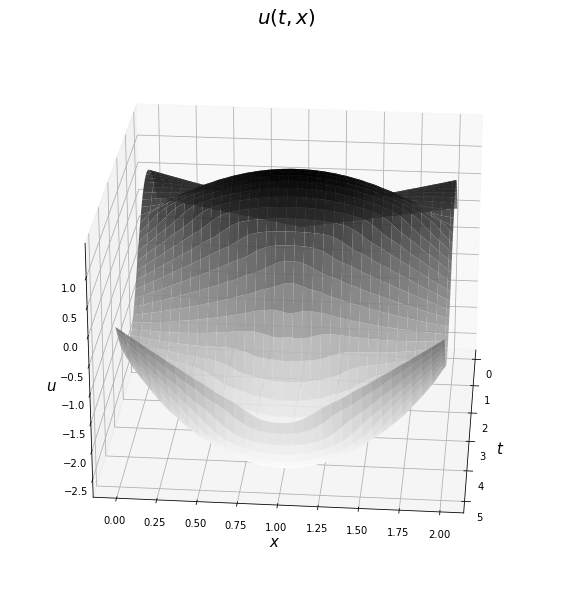

In [16]:
plot_3D(t,x,u1, elev=elev, azim=5, cmap = cmap)

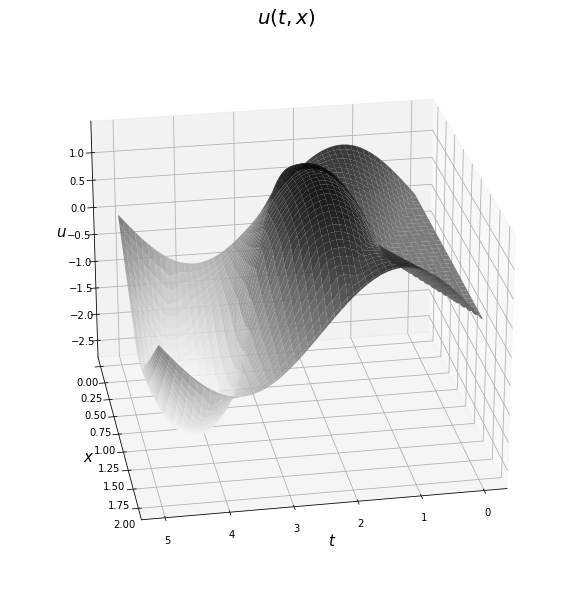

In [17]:
plot_3D(t,x,u2, elev=elev, azim=80, cmap = cmap)

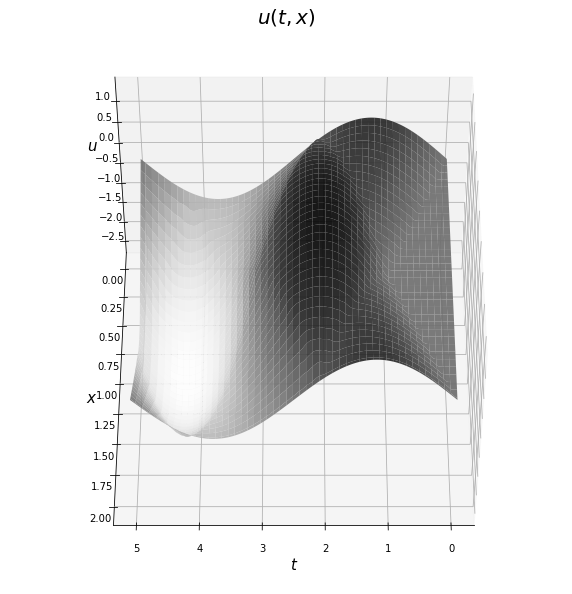

In [18]:
plot_3D(t,x,u3, elev=50, azim=90, cmap = cmap)

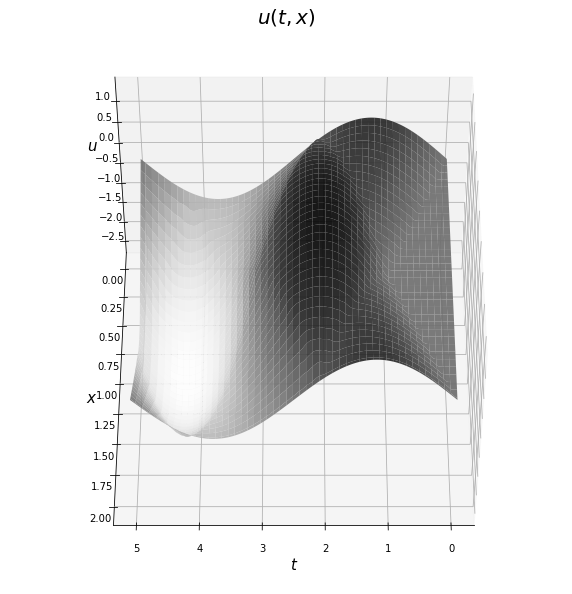

In [19]:
plot_3D(t,x,u4, elev=50, azim=90, cmap = cmap)

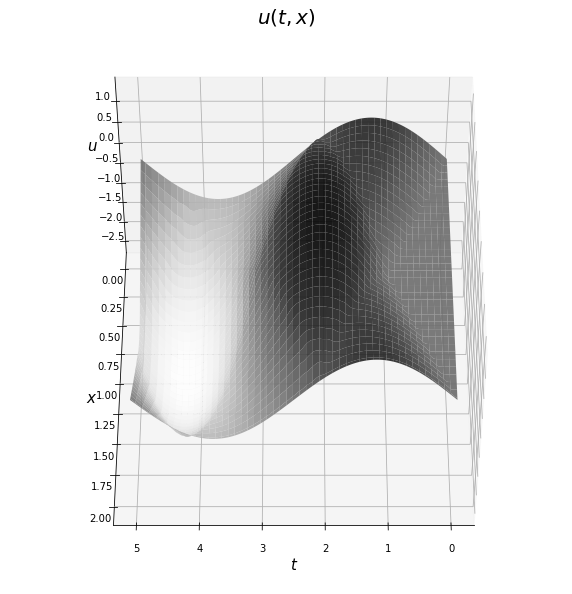

In [20]:
plot_3D(t,x,u5, elev=50, azim=90, cmap = cmap)

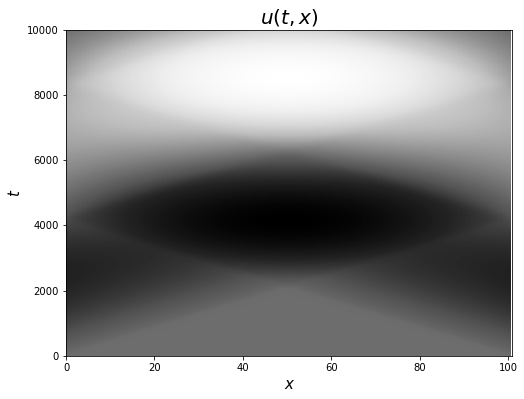

In [21]:
plot_2D(u3, Nx, Nt, cmap = cmap)

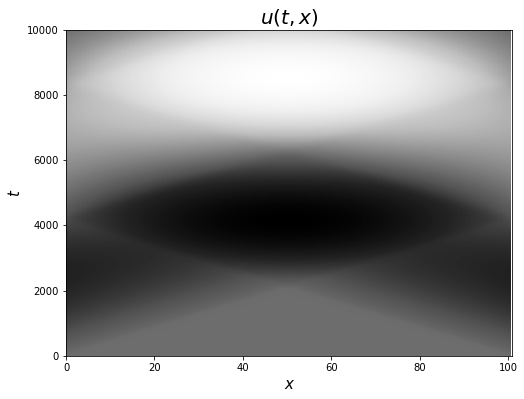

In [22]:
plot_2D(u5, Nx, Nt, cmap = cmap)